In [1]:
import tensorflow as tf
import torchaudio
import sys,os
import pandas as pd
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import librosa
import librosa.display
import re

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn import metrics
# models
from sklearn.ensemble import RandomForestClassifier




from sklearn.metrics import accuracy_score



# -  Data Loading & Feature Extraction

In [2]:
sample_rate = 16000
def extract_features(audio):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
 
    return mfccs   # it returns a np.array with size (40,'n') where n is the number of audio frames.

In [3]:
# there are 2703 audio files (ext: .flac)

root = "LibriSpeech/dev-clean/"
df = pd.DataFrame(columns=['speaker_id', 'features'])              

i = 0
max_pad_len = 1021

# loading the features in the first dataframe
for path, subdirs, files in os.walk(root):
    for name in files:
        speaker_id = path.split('/')[2]
        speaker_id = speaker_id.split('\\')[0]

        if name.endswith(".flac"):
            sound, sample_rate = librosa.load(os.path.join(path, name), sr=16000)
            data = extract_features(sound)
            
            # zero-pad the mfccs features 
            # max_pad_len is the biggest number of audio frames
            # obtained by extracting features (mfccs) from all the audio files.
            pad_width = max_pad_len - data.shape[1]
            data = np.pad(data, pad_width=((0,0), (0, pad_width)), mode='constant')
            df.loc[i] = [speaker_id] + [data]
            i += 1
            
# loading the labels in the second dataframe
root = "LibriSpeech/"
labels = pd.DataFrame(columns=['speaker_id', 'gender'])

f = open("LibriSpeech/SPEAKERS.txt", "r", encoding="UTF8").readlines()
i = 0
for idx, line in enumerate(f):
    if idx > 11:
        parsed = re.split('\s+',line)
        if parsed[4] == 'dev-clean':
            labels.loc[i] = parsed[0], parsed[2] # speaker_id and label (M/F)
            i += 1   

dataset = pd.merge(df, labels, on='speaker_id')  # merging the two dataframes.

# REPLACE CATEGORICAL VALUES INTO NUMERIC VALUES
dataset["gender"].replace({"M": 1, "F": 0}, inplace=True)
dataset.head(10)

,speaker_id,features,gender
0,1272,"[[-528.69946, -501.22946, -503.7977, -518.0384...",1
1,1272,"[[-572.3399, -562.6875, -547.48303, -514.67474...",1
2,1272,"[[-529.91327, -494.09573, -478.23132, -459.471...",1
3,1272,"[[-541.216, -504.3137, -481.6609, -455.47534, ...",1
4,1272,"[[-490.3293, -442.96283, -405.95102, -379.4946...",1
5,1272,"[[-420.6933, -391.5817, -402.1242, -425.6603, ...",1
6,1272,"[[-579.5069, -540.7488, -504.11133, -499.32086...",1
7,1272,"[[-567.024, -525.76654, -494.5746, -477.10895,...",1
8,1272,"[[-500.19687, -459.13394, -436.62683, -416.311...",1
9,1272,"[[-562.1569, -521.306, -467.74948, -429.08594,...",1


# EDA

In [4]:
dataset['gender'].value_counts()

0    1374
1    1329
Name: gender, dtype: int64

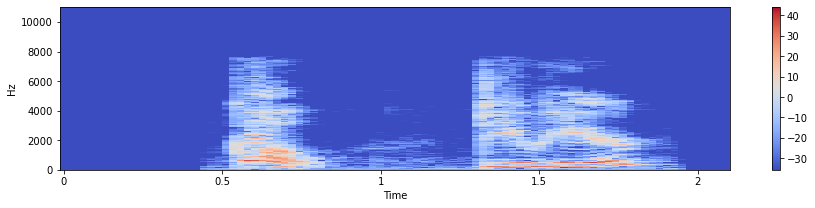

In [5]:
x, sr = librosa.load(r'C:\Users\Lenovo\Desktop\gender_idefication\LibriSpeech\dev-clean\84\121123\84-121123-0000.flac')
# Spectrogram of frequency
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 3))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

## Mel-Frequency Cepstral Coefficients (MFCCs)

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_20092/400924730.py:2: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(x, sr=sr)


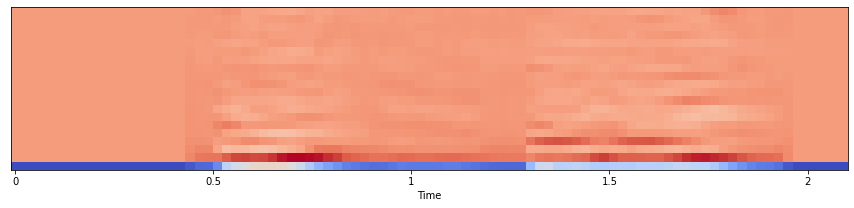

In [6]:
y, sr = librosa.load(r'C:\Users\Lenovo\Desktop\gender_idefication\LibriSpeech\dev-clean\84\121123\84-121123-0000.flac')
mfccs = librosa.feature.mfcc(x, sr=sr)
# Displaying  the MFCCs:
plt.figure(figsize=(15, 3))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## Amplitude

Text(54.625, 0.5, 'Amplitude')

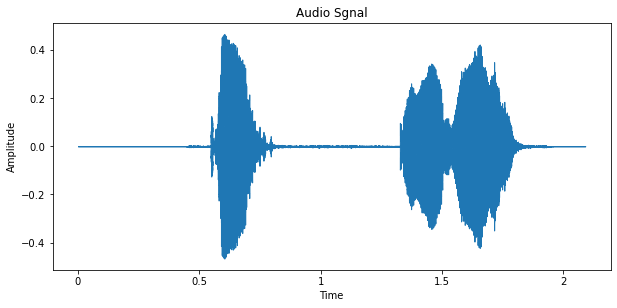

In [7]:
path = r'C:\Users\Lenovo\Desktop\gender_idefication\LibriSpeech\dev-clean\84\121123\84-121123-0000.flac'
sound, sample_rate = librosa.load(path, sr=16000)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
librosa.display.waveshow (sound, sr= sample_rate)
plt.title('Audio Sgnal')
plt.ylabel("Amplitude")

## Spectogram

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_20092/2633925381.py:2: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectogram = librosa.feature.melspectrogram(sound, sr=sample_rate)


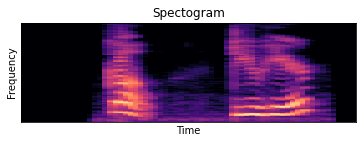

In [8]:
plt.subplot(2, 1, 2)
spectogram = librosa.feature.melspectrogram(sound, sr=sample_rate)
log_spectogram = librosa.power_to_db(spectogram, ref=np.max)
librosa.display.specshow(log_spectogram)
plt.title('Spectogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

#  Train  Test split



In [9]:
train_test_ratio = 0.80
n_sounds = 2703

def split_train_test(train_test_ratio, n_sounds):
    
    train = pd.DataFrame(columns=['speaker_id', 'features' , 'gender'])
    test = pd.DataFrame(columns=['speaker_id', 'features', 'gender'])
    
    train_elems = int(np.floor(n_sounds*train_test_ratio))
    test_elems = n_sounds - train_elems

  

    male_train = int(np.floor(dataset['gender'].value_counts()[0]* train_test_ratio))
    male_test = int(np.ceil(dataset['gender'].value_counts()[0]* (1-train_test_ratio)))
    train_sizes = [male_train, train_elems]
    test_sizes = [male_test + male_train, n_sounds]
    
    for gender in range(2):  
        if gender == 0:
            gender_set = dataset[dataset["gender"] == gender]   # MALES
        elif gender == 1:
            gender_set = dataset[dataset["gender"] == gender]   # FEMALES

        ordered_gender_set = gender_set['speaker_id'].value_counts()
        i = 0
        while (train.shape[0] < train_sizes[gender]):
            train = train.append(gender_set[gender_set["speaker_id"] == ordered_gender_set.index[i]])
            i += 1
        while (test.shape[0] + train.shape[0] != test_sizes[gender]): 
            test = test.append(gender_set[gender_set["speaker_id"] == ordered_gender_set.index[i]])
            i += 1

    return train, test
   
train, test = split_train_test(train_test_ratio, n_sounds)

# ML Algorithms

In [10]:


X_train = np.mean(np.array(train.features.tolist()), axis = 2)
X_test = np.mean(np.array(test.features.tolist()), axis = 2)
y_train = np.array(train.gender.tolist())
y_test = np.array(test.gender.tolist())

le = LabelEncoder()
yy_train = to_categorical(le.fit_transform(y_train)) 
yy_test = to_categorical(le.fit_transform(y_test)) 

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2176, 40), (2176,), (527, 40), (527,))

## Support Vector Machine

In [11]:
from sklearn import svm

svc = svm.SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)

print("Accuracy: ", accuracy)
print("tpr: ", tpr)
print("fpr: ", fpr)


Accuracy:  0.8178368121442126
tpr:  [0.         0.83032491 1.        ]
fpr:  [0.    0.196 1.   ]


## Naive base

In [12]:
from sklearn import naive_bayes

clf = naive_bayes.GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)

print("Accuracy: ", accuracy)
print("fpr: ", fpr)
print("tpr: ", tpr)


Accuracy:  0.8216318785578748
fpr:  [0.    0.076 1.   ]
tpr:  [0.         0.72924188 1.        ]


# KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)

print("Accuracy: ", accuracy)
print("fpr: ", fpr)
print("tpr: ", tpr)


Accuracy:  0.7362428842504743
fpr:  [0.    0.264 1.   ]
tpr:  [0.         0.73646209 1.        ]


## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)

print("Accuracy: ", accuracy)
print("fpr: ", fpr)
print("tpr: ", tpr)

Accuracy:  0.8690702087286527
fpr:  [0.    0.016 1.   ]
tpr:  [0.         0.76534296 1.        ]


## MLP

In [15]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)

print("Accuracy: ", accuracy)
print("fpr: ", fpr)
print("tpr: ", tpr)

Accuracy:  0.8614800759013282
fpr:  [0.    0.076 1.   ]
tpr:  [0.         0.80505415 1.        ]


# PCA

In [16]:
from sklearn.decomposition import PCA

accuracy_list=[]
for i in range (40,2,-1):
    pca = PCA(n_components=i)
    pca.fit(X_train)
    X_train_reduced = pca.transform(X_train)
    X_test_reduced = pca.transform(X_test)
    
    
    clf = RandomForestClassifier()
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_test_reduced)
    acc = accuracy_score(y_test, y_pred)
    print(acc)
    accuracy_list.append(acc)

df_pca_results = pd.DataFrame(accuracy_list) 
df_pca_results.to_csv('df_pca_results.csv') 

0.7628083491461101
0.7552182163187856
0.7760910815939279
0.7533206831119544
0.7571157495256167
0.7552182163187856
0.7495256166982922
0.7419354838709677
0.7400379506641366
0.7609108159392789
0.7438330170777988
0.7324478178368121
0.7685009487666035
0.7893738140417458
0.7817836812144212
0.7628083491461101
0.7552182163187856
0.7817836812144212
0.7722960151802657
0.7912713472485768
0.777988614800759
0.7817836812144212
0.7855787476280834
0.7874762808349146
0.7950664136622391
0.8083491461100569
0.7969639468690702
0.7722960151802657
0.7855787476280834
0.7950664136622391
0.8026565464895635
0.7988614800759013
0.7798861480075902
0.8102466793168881
0.8121442125237192
0.650853889943074
0.6413662239089184
0.6679316888045541
0.6091081593927894


In [17]:
df_pca_results


,0
0,0.762808
1,0.755218
2,0.776091
3,0.753321
4,0.757116
5,0.755218
6,0.749526
7,0.741935
8,0.740038
9,0.760911
